# Training Data




## This notebook assumes you have the DC2 data downloaded  

You will have to change directory paths

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
import deepdisc

In [2]:
# Standard imports
import sys, os
import numpy as np
import time
import glob

import scarlet
import sep

import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

# Astrodet imports
import deepdisc.preprocessing.detection as detection
import deepdisc.preprocessing.process as process

from deepdisc.astrodet.hsc import get_tract_patch_from_coord, get_hsc_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
from skimage.util.shape import view_as_blocks
from matplotlib import colors

import pandas as pd
import h5py
import json

In [3]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+g11d1363
1.23.4
1.2.1


### Run Scarlet to produce segmentation maps

First, let's test scarlet using one DC2 image. The DC2 image data is divided into "tracts" and "patches" on the sky. You can get the data here https://data.lsstdesc.org/.

You will need to change the directory paths below

In [3]:
from deepdisc.preprocessing.get_data import get_cutout
filters = ['u','g','r','i','z','y']
#dirpath = '/home/g4merz/DC2/coadd-t3828-t3829/deepCoadd-results/'
dirpath = '/home/shared/hsc/DC2/raw_data/'
nblocks=16 #The number of cutouts per side of an image.  4k CCDs are too large to train with, so we reduce the size


### No input catalog


If you don't have an input catalog that contains object locations, no worries! The object detection can be done with ```sep``` a standard code for astronmical image processing.


But first, we need to grab the images we want to preprocess.  The function ```get_cutout``` produces an image cutout from a larger "patch" and is specific to the file format of the data used in the tutorial.  You will need to make your own custom function to get an image saved in a different format

In [39]:
tract = 3828
patch='2,2'
sp = 18
cutout,datsm, _ = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=False)

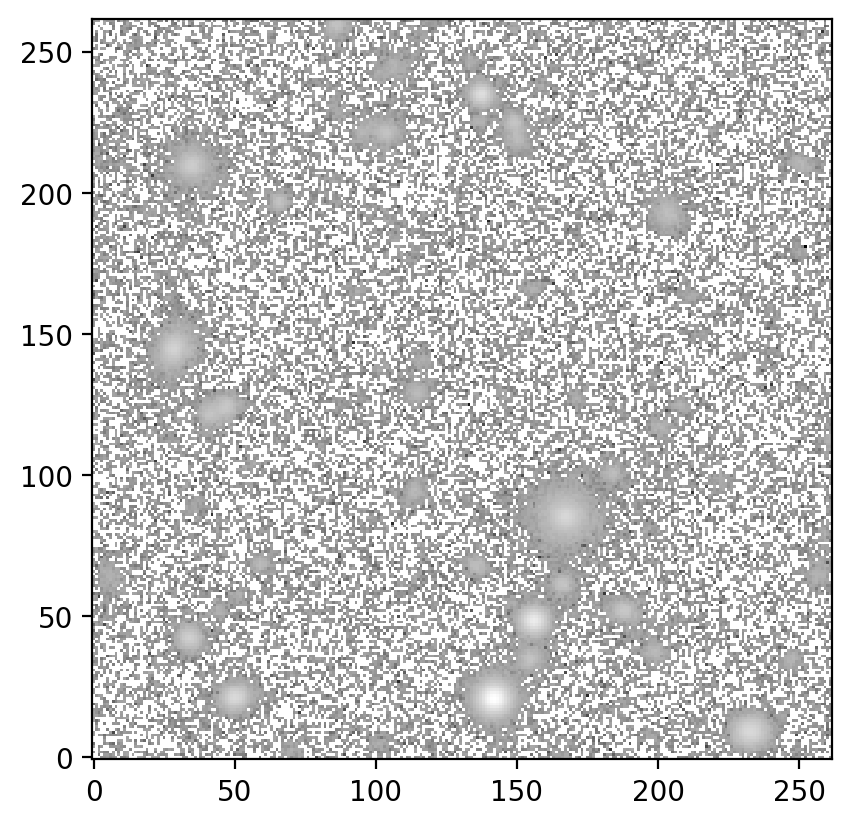

In [40]:
plt.imshow(datsm[1],norm=colors.LogNorm())

#### Now we can run detection and segmentation on the cutout image

To produce labels for an image, use ```deepdisc.preprocessing.detection.run_scarlet```.  The main inputs you will need are an image, a list of filters, and a psf (either an image or a gaussian standard deviation).
Check the API documentation for details. 

This will produce a few intermediate objects that contain all of the relevant information.  However, we format them into FITS files for ease of access.  This is done using ```deeepdisc.preprocess.process.write_scarlet_results```

In [27]:

#This function is specific to the data format. You will need your own function to produce "datas" to input to run_scarlet

def generate_training_data_example(dirpath, tract, patch, sp, outdir, plot_image=False, plot_stretch_Q=False, plot_scene=False,
                                   plot_likelihood=False, write_results=True):
    """
    Parameters
    ----------
    c : SkyCoord object
          The ra, dec pointing (single or lists of pointings)
    plot_image : bool
          Whether or not to plot the image
    plot_stretch_Q : bool
          Whether or not to plot different normalizations of your image using the stretch, Q parameters.
    plot_scene : bool
           Whether or not plot scene with scarlet
    plot_likelihood : bool
           Whether or not plot the log likelihood of the scarlet fitting
    write_results : bool
          Whether or not to write results to FITS file
    cutout_size : [int, int]
          Cutout shape of image
          
    Returns
    -------
    The scarlet image test in FITS files.
    
    """
    print(tract,patch,sp)
    print()
    
    cutout,datas, _ = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=False)
    
    ### Run scarlet on image ###

    # Image pixel scale in arcsec/pixel
    ps = 0.2
    # Approximate PSF size
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
    
       
    # Run Scarlet
    out = detection.run_scarlet(datas, filters, catalog=None, lvl=2, sigma_model=1, sigma_obs=sigma_obs, psf=None, plot_scene=plot_scene,
                         max_chi2=1000000, morph_thresh=1, stretch=1, Q=5, 
                         plot_wavelet=False, plot_likelihood=plot_likelihood, plot_sources=False, add_ellipses=False,
                         add_labels=False, add_boxes=False, lvl_segmask=2, maskthresh=0.005,return_models=False)

    # Unpack output
    observation, starlet_sources, model_frame, catalog, segmentation_masks = out

    
    # Save Scarlet data to FITS file
    if write_results:
        filenames = process.write_scarlet_results_nomodels(datas, observation, starlet_sources, model_frame, 
                                             segmentation_masks, outdir=outdir, 
                                             filters=filters, s=f'{tract}_{patch}_{sp}', source_catalog=catalog)
    
        print(f'\nSaved scarlet results as {filenames} \n')
    
        

In [ ]:
%%time
outdir='/home/g4merz/ddtutorials/'
generate_training_data_example(dirpath, tract='3828',patch='1,2',sp=4,plot_scene=False, plot_likelihood=False, write_results=True, outdir=outdir)


### Using an input catalog

The cells below assume you have an input catalog `all_tracts_cat.csv` corresponding to the tracts and patches you've downloaded.  We can run the code without one, but it is necessary for truth-matching any quantities

In [46]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma

dall=pd.read_csv('/home/shared/hsc/DC2/raw_data/all_tracts_truth_cat.csv')
#dall=pd.read_csv('/home/g4merz/DC2/nersc_data/data/tracts_data/all_tracts_cat.csv')

ra_all = dall['ra'][:].values
dec_all = dall['dec'][:].values
allcatalog = SkyCoord(ra=ra_all*u.degree, dec=dec_all*u.degree)

In [49]:
def get_cutout_cat(dirpath,dcat,skycoords, id_col, tract,patch,sp,nblocks=4,filters=['u','g','r','i','z','y']):
    '''
        WARNING!!!!!
        It is not efficient to have the full catalog (defined here as dall) as input to a function when doing multiprocesing.  
        Keep it in the top level process
    '''
    cutout,datsm, psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nblocks,filters=filters,plot=False, get_psf=True)
    xs,ys = cutout.wcs.world_to_pixel(skycoords)

    inds = np.where((xs>=0) & (xs<cutout.shape[1]-1) & (ys>=0) & (ys<cutout.shape[0]-1))[0]
    
    
    dcut = dcat.iloc[inds]
    

    dcut['new_x'] = xs[inds]
    dcut['new_y'] = ys[inds]
    
    #dcut = dcut[dcut['mag_i']<25.3]

    
    column_to_move = dcut.pop(id_col)

    # insert column with insert(location, column_name, column_value)
    dcut.insert(0, id_col, column_to_move)
    dcut.sort_values(by=id_col)
    
    return datsm, dcut, psf

In [50]:
datsm,dcut,psf = get_cutout_cat(dirpath, dall, allcatalog, 'id', '3828','1,2',4,nblocks=8)



/tmp/ipykernel_1865293/2061951149.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_1865293/2061951149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]


(-0.5, 524.5, -0.5, 524.5)

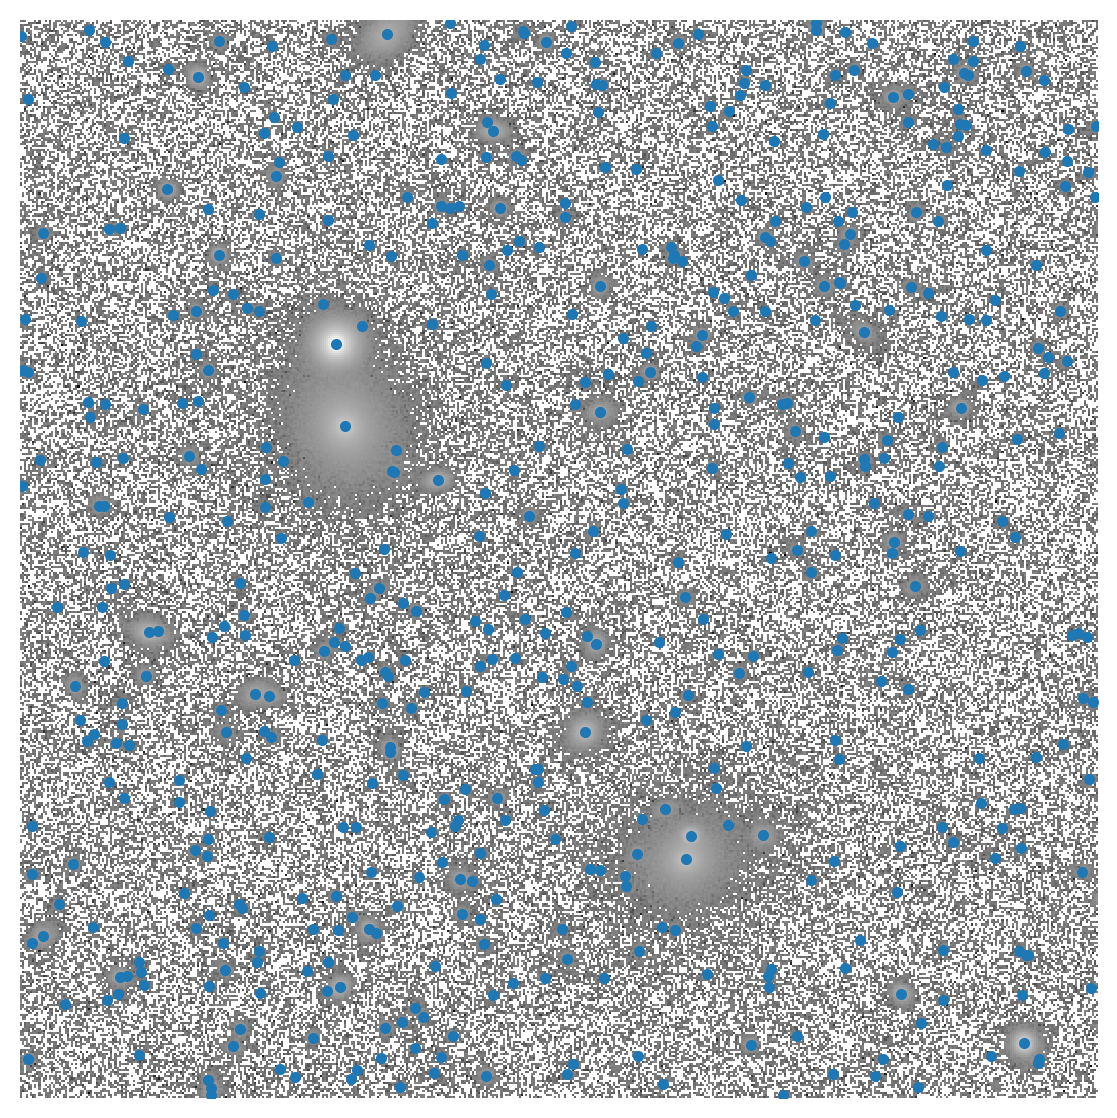

In [16]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
#plt.figure(figsize=(7,7))
ax.imshow(datsm[3],norm=colors.LogNorm(),origin='lower')
ax.scatter(dcut['new_x'].values,dcut['new_y'].values,marker='.')
ax.axis('off')

#ax[1].imshow(datsm2[3],norm=colors.LogNorm(),origin='lower')
#ax[1].scatter(dcut2['new_x'].values,dcut2['new_y'].values,marker='.')
#ax[1].axis('off')

In [54]:
filters = ['u','g','r','i','z','y']


def generate_training_data_example(dirpath, tract, patch, sp, outdir, plot_image=False, plot_stretch_Q=False, plot_scene=False,
                                   plot_likelihood=False, write_results=True):
    """
    Parameters
    ----------
    c : SkyCoord object
          The ra, dec pointing (single or lists of pointings)
    plot_image : bool
          Whether or not to plot the image
    plot_stretch_Q : bool
          Whether or not to plot different normalizations of your image using the stretch, Q parameters.
    plot_scene : bool
           Whether or not plot scene with scarlet
    plot_likelihood : bool
           Whether or not plot the log likelihood of the scarlet fitting
    write_results : bool
          Whether or not to write results to FITS file
    cutout_size : [int, int]
          Cutout shape of image
          
    Returns
    -------
    The scarlet image test in FITS files.
    
    """
    
    
    datas,dcut,psf = get_cutout_cat(dirpath,dall,allcatalog,'id',tract=tract,patch=patch,sp=sp,nblocks=nblocks)
    #cut = np.where(dcut['mag_i'].values<25.3)[0]
    #dcut = dcut.iloc[cut]
    
    #cutout,datas,psf = get_cutout(dirpath,tract=tract,patch=patch,sp=sp,nblocks=nb,filters=filters,plot=False)


    ### Run scarlet on image ###

    # HSC pixel scale in arcsec/pixel
    ps = 0.2
    # Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
    
    
    #psf = np.load(f'/home/g4merz/DC2/nersc_data/data/psfs/{tract}_{patch}_0_psfs.npy')
    
    # Run Scarlet
    out = detection.run_scarlet(datas, filters, catalog=dcut, lvl=2, sigma_model=1, sigma_obs=sigma_obs, psf=psf, plot_scene=plot_scene,
                         max_chi2=1000000, morph_thresh=1, stretch=1, Q=5, 
                         plot_wavelet=False, plot_likelihood=plot_likelihood, plot_sources=False, add_ellipses=False,
                         add_labels=False, add_boxes=False, lvl_segmask=2, maskthresh=0.005,return_models=False)

    # Unpack output
    #observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out
    observation, starlet_sources, model_frame, catalog, segmentation_masks = out

    
    # Save Scarlet data to FITS file
    if write_results:
        filenames = process.write_scarlet_results_nomodels(datas, observation, starlet_sources, model_frame, 
                                             segmentation_masks, outdir=outdir, 
                                             filters=filters, s=f'{tract}_{patch}_{sp}', source_catalog=catalog)
    
        print(f'\nSaved scarlet results as {filenames} \n')
    
        

/tmp/ipykernel_1865293/2061951149.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_1865293/2061951149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]
No flux in morphology model for source at (4.8566570126986335, 192.3978758655976)
No flux in morphology model for source at (156.3428668810957, 46.73144519767811)


Source catalog has  133 objects
Initializing starlet sources to be fit.


No flux in morphology model for source at (67.96124508293269, 238.5802424436115)
No flux in morphology model for source at (137.73664723412912, 235.1336232367812)
No flux in morphology model for source at (151.30783233206603, 15.49913299020045)
No flux in morphology model for source at (205.80671436111697, 69.20862945785666)
No flux in morphology model for source at (254.45607877980729, 254.17204999562637)
No flux in morphology model for source at (254.82916063899484, 193.02193773697945)
No flux in morphology model for source at (190.15911361222243, 96.36605434686498)
No flux in morphology model for source at (220.00362330847292, 34.43471952795517)
No flux in morphology model for source at (73.34399792161366, 203.80719093122207)
No flux in morphology model for source at (66.2767218112549, 223.11999092828228)
No flux in morphology model for source at (146.0457846056479, 196.70802377106156)
No flux in morphology model for source at (11.427058219639548, 91.917219322655)
No flux in morphol

Fitting Blend model.
Scarlet ran for 12 iterations to logL = -382118.035420464
18.239954710006714
Extracting deblended catalog.


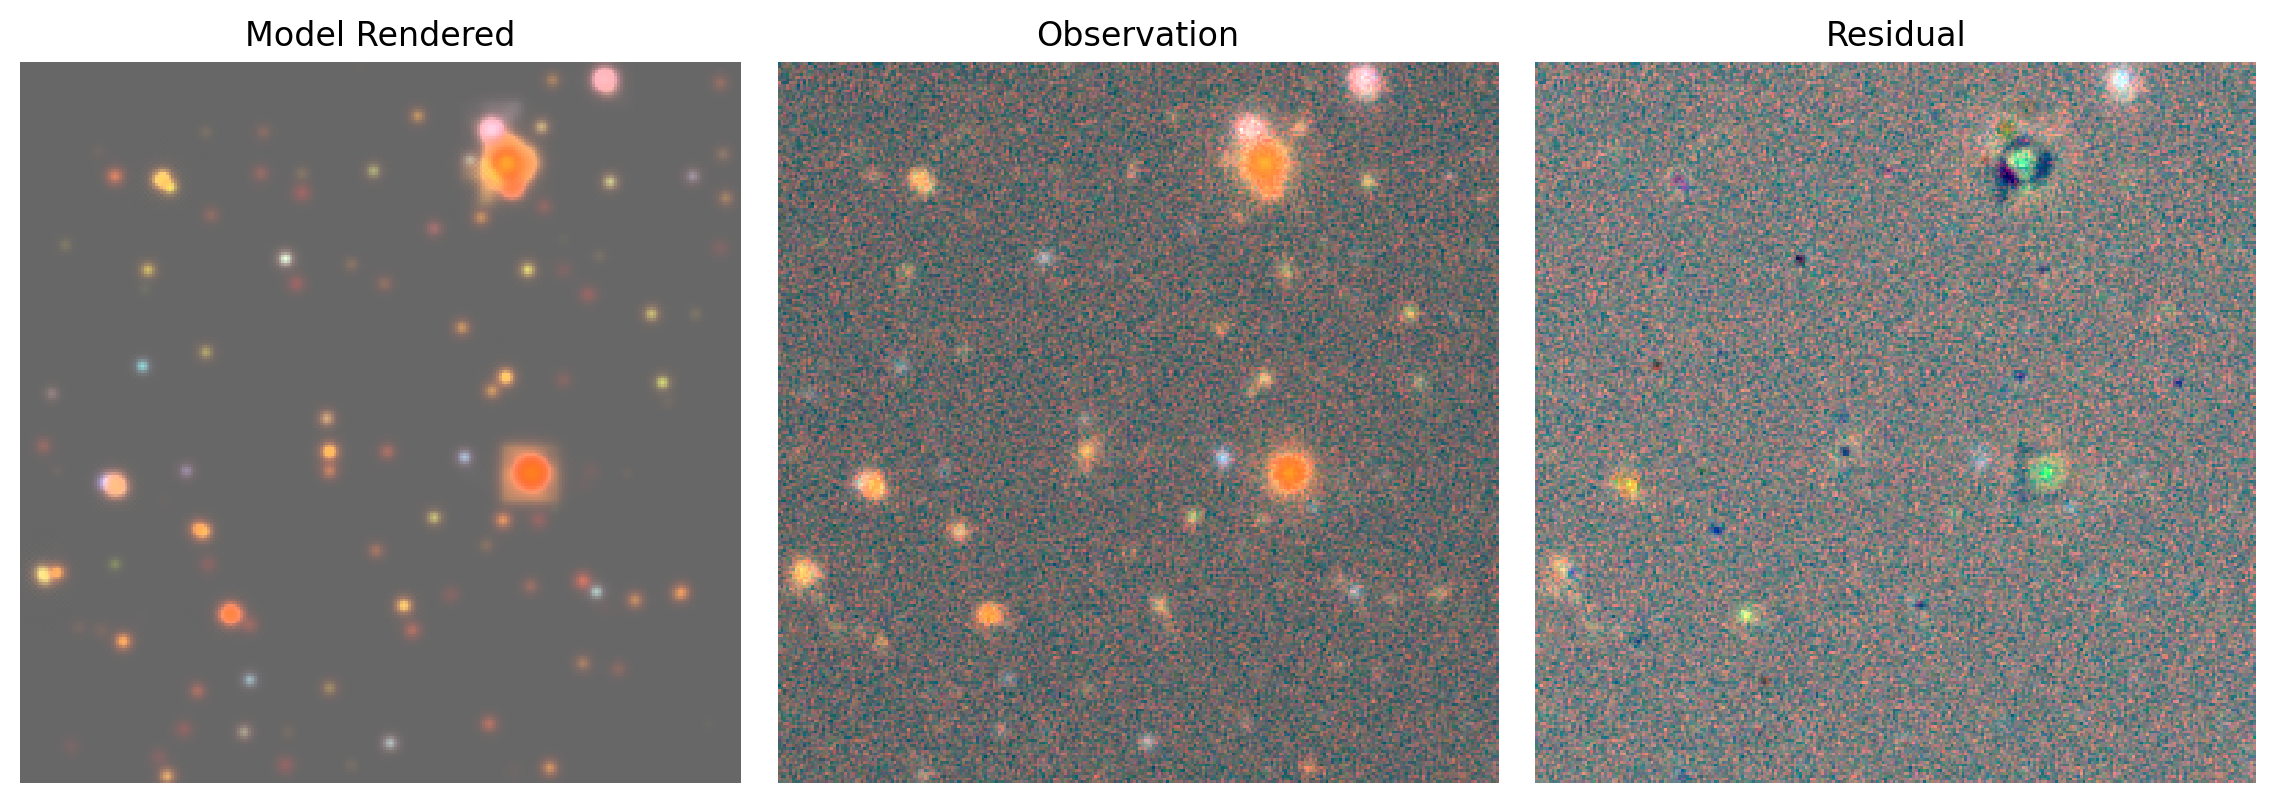


Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_3828_1,2_18_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_3828_1,2_18_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_3828_1,2_18_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_3828_1,2_18_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_3828_1,2_18_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_3828_1,2_18_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/3828_1,2_18_scarlet_segmask.fits'} 

CPU times: user 28.4 s, sys: 210 ms, total: 28.6 s
Wall time: 26.3 s


In [55]:
%%time
outdir='/home/g4merz/ddtutorials/'
generate_training_data_example(dirpath, tract='3828',patch='1,2',sp=18,plot_scene=True, plot_likelihood=False, write_results=True, outdir=outdir)


#### Let's run a few more times to get a set of images

In [61]:
generate_training_data_example(dirpath, tract='3828',patch='1,2',sp=17,plot_scene=False, plot_likelihood=False, write_results=True, outdir=outdir)


/tmp/ipykernel_1865293/2061951149.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_1865293/2061951149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]
No flux in morphology model for source at (218.3070109456812, 99.2416584235325)


Source catalog has  109 objects
Initializing starlet sources to be fit.


No flux in morphology model for source at (94.67594995561558, 225.1134857168836)
No flux in morphology model for source at (49.09945510661055, 193.20271229321042)
No flux in morphology model for source at (248.86241752741444, 70.40285406602743)
No flux in morphology model for source at (115.70031321197985, 188.64343529850157)
No flux in morphology model for source at (64.48731036841855, 125.63588542193065)
No flux in morphology model for source at (1.044872974847749, 182.987356362617)
No flux in morphology model for source at (51.998881765652186, 94.56574516232467)
No flux in morphology model for source at (93.01757206149341, 228.9946473001437)
No flux in morphology model for source at (22.38093496411966, 4.981205480895369)
No flux in morphology model for source at (57.519048406034926, 64.59995863480253)
No flux in morphology model for source at (110.41891163182754, 9.894160240013662)
No flux in morphology model for source at (245.17932436185765, 73.62393713359779)
No flux in morpholog

Fitting Blend model.
Scarlet ran for 5 iterations to logL = -382214.71846933855
10.130998373031616
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_3828_1,2_17_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_3828_1,2_17_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_3828_1,2_17_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_3828_1,2_17_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_3828_1,2_17_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_3828_1,2_17_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/3828_1,2_17_scarlet_segmask.fits'} 



In [62]:
generate_training_data_example(dirpath, tract='3828',patch='1,2',sp=16,plot_scene=False, plot_likelihood=False, write_results=True, outdir=outdir)


/tmp/ipykernel_1865293/2061951149.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_1865293/2061951149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]
No flux in morphology model for source at (34.215208205953786, 217.35673465162472)


Source catalog has  119 objects
Initializing starlet sources to be fit.


No flux in morphology model for source at (193.11070345324515, 65.12487340850748)
No flux in morphology model for source at (221.05143185157885, 0.7492544866054232)
No flux in morphology model for source at (101.28824767350216, 238.23671345504408)
No flux in morphology model for source at (233.49110628210474, 110.32720059355597)
No flux in morphology model for source at (86.97042768460051, 70.51089864074856)
No flux in morphology model for source at (200.2937977193551, 90.03842204550347)
No flux in morphology model for source at (207.1677354178546, 135.52044369708892)
No flux in morphology model for source at (105.05044080479456, 55.38957839943032)
No flux in morphology model for source at (61.06991255288176, 86.05271477497627)
No flux in morphology model for source at (230.54696021899326, 118.65910918205009)
No flux in morphology model for source at (245.34923312978117, 19.674303958017845)
No flux in morphology model for source at (136.86152141165167, 28.331969867869702)
No flux in mo

Fitting Blend model.
Scarlet ran for 8 iterations to logL = -382418.8259674484
12.833014965057373
Extracting deblended catalog.

Saved scarlet results as {'img_U': '/home/g4merz/ddtutorials/U_3828_1,2_16_scarlet_img.fits', 'img_G': '/home/g4merz/ddtutorials/G_3828_1,2_16_scarlet_img.fits', 'img_R': '/home/g4merz/ddtutorials/R_3828_1,2_16_scarlet_img.fits', 'img_I': '/home/g4merz/ddtutorials/I_3828_1,2_16_scarlet_img.fits', 'img_Z': '/home/g4merz/ddtutorials/Z_3828_1,2_16_scarlet_img.fits', 'img_Y': '/home/g4merz/ddtutorials/Y_3828_1,2_16_scarlet_img.fits', 'segmask': '/home/g4merz/ddtutorials/3828_1,2_16_scarlet_segmask.fits'} 



### Annotation generation

Now we can reformat the scarlet output to the format that detectron2 (and thus deepdisc) expects.  This is done by creating a list of dictionaries, with each dict containing annotations that have the ground truth information.  Take a look at the detectron2 docs for more information on the format expected

In [63]:
from deepdisc.data_format.file_io import DDLoader
from deepdisc.data_format.annotation_functions.annotate_dc2 import annotate_dc2

Each image cutout is saved into separate FITS files per band, along with mask files (which contain the object location/footprint information). Here we create a DDLoader class, which helps gather output files and format them

In [19]:
%%time
outdir='./'
nb=8
generate_training_data_example(dirpath, tract='3828',patch='1,2',sp=4,plot_scene=False, plot_likelihood=False, write_results=True, outdir=outdir)


3828 1,2 4

(6, 4200, 4200)
[525, 525]


/tmp/ipykernel_3239168/2061951149.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_x'] = xs[inds]
/tmp/ipykernel_3239168/2061951149.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcut['new_y'] = ys[inds]


Source catalog has  182 objects
Initializing starlet sources to be fit.


No flux in morphology model for source at (209.72048181298032, 267.9881317471154)
No flux in morphology model for source at (188.5293816510548, 97.34488385190161)
No flux in morphology model for source at (358.268929609163, 509.186786307735)
No flux in morphology model for source at (175.53232860311982, 121.8747957374926)
No flux in morphology model for source at (24.594526692611907, 103.16194218067358)
No flux in morphology model for source at (399.01324522401774, 9.941506946473964)
No flux in morphology model for source at (396.6881047666475, 398.57640248103326)
No flux in morphology model for source at (497.8045912824191, 396.22481004178735)
No flux in morphology model for source at (391.2592264122586, 229.09565006552657)
No flux in morphology model for source at (18.388651363947247, 3.547778266623027)
No flux in morphology model for source at (405.2788180630714, 227.80441014273856)
No flux in morphology model for source at (81.76320703214515, 263.2321413857162)
No flux in morpholog

Fitting Blend model.
Scarlet ran for 15 iterations to logL = -2321654.6215960835
69.64574384689331
Extracting deblended catalog.

Saved scarlet results as {'img_U': './U_3828_1,2_4_scarlet_img.fits', 'img_G': './G_3828_1,2_4_scarlet_img.fits', 'img_R': './R_3828_1,2_4_scarlet_img.fits', 'img_I': './I_3828_1,2_4_scarlet_img.fits', 'img_Z': './Z_3828_1,2_4_scarlet_img.fits', 'img_Y': './Y_3828_1,2_4_scarlet_img.fits', 'segmask': './3828_1,2_4_scarlet_segmask.fits'} 

CPU times: user 1min 27s, sys: 2.68 s, total: 1min 30s
Wall time: 1min 30s


We can split the set of produced cutout images/mask files into different datasets with the ```random_sample``` functionality

This will make a copy of the data, so we can delete the old images

In [68]:
for file in glob.glob(os.path.join(outdir,'*.fits')):
    os.remove(file)

Generate a new filedict for the new train directory

In [71]:
loader = DDLoader().generate_filedict('/home/g4merz/ddtutorials/train/', ['U', 'G', 'R', 'I', 'Z','Y'], '*_scarlet_img.fits', '*_scarlet_segmask.fits')
filedict = loader.filedict
img_files = np.transpose([filedict[filt]["img"] for filt in filedict["filters"]])

In [74]:
from deepdisc.data_format import conversions
from deepdisc.data_format import conversions
from deepdisc.data_format.conversions import fitsim_to_numpy, ddict_to_hdf5, fitsim_to_hdf5
from deepdisc.data_format.annotation_functions.annotate_dc2 import annotate_dc2


Format the files for deepdisc

In [77]:

dataset_dicts=[]
dataset_dicts = loader.generate_dataset_dict(annotate_dc2).get_dataset()  


Now ```dataset_dicts``` contains the formatted ground truth for deepdisc.

In [80]:
from detectron2.utils.file_io import PathManager
dfile ='/home/g4merz/ddtutorials/train/train_dicts.json'
with PathManager.open(dfile, "w") as f:
    json.dump(dataset_dicts, f)


It may also be useful to format the FITS images by scarlet into numpy .npy files.  For convenience, this can be done using some conversion utilities

In [81]:
from deepdisc.data_format.conversions import fitsim_to_numpy

In [84]:
fitsim_to_numpy(img_files,'/home/g4merz/ddtutorials/train/')

Clean up the FITS files

In [85]:
for file in glob.glob('/home/g4merz/ddtutorials/train/*.fits'):
    os.remove(file)

Now you have everything you need to run DeepDISC!